In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import deepchem as dc
import os
from tqdm import tqdm
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch.nn import BatchNorm1d

C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GCNLayer(nn.Module):
    
    def __init__(self,in_feats,out_feats,batch_norm=True):
        
        super().__init__()
        
        self.graph_conv = GCNConv(in_channels=in_feats,out_channels=out_feats)
        self.dropout = nn.Dropout(p=0.6)
        self.batch_norm = batch_norm
        
        ## implementing residual
        self.res_connection = nn.Linear(in_feats,out_feats)
        
        ## implementing BatchNorm
        if self.batch_norm:
            self.bn = BatchNorm1d(out_feats)
        
    def reset_parameters(self):
        """Reinitialize model parameters."""
        self.graph_conv.reset_parameters()
        self.res_connection.reset_parameters()
      
        
    def forward(self,x,edge_index):
        
        ### Extracting data from batch
        new_feats = self.graph_conv(x,edge_index)
        res_feats = F.relu(self.res_connection(x))
        new_feats = new_feats + res_feats ### residual added
        new_feats = self.dropout(new_feats)
        
        if self.batch_norm:
            return self.bn(new_feats)
        else:
            return new_feats

In [4]:
class GCNNetwork(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        ## GCN layers
        self.GCNConv1 = GCNLayer(30,64,True)
        self.GCNConv2 = GCNLayer(64,32,False)
         
        ### Predictor layers
        self.lin1 = nn.Linear(32,128)
        self.lin2 = nn.Linear(128,1)
        
        
    def forward(self,data):
        
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        
        x = F.relu(self.GCNConv1(x,edge_index))
        x = F.relu(self.GCNConv2(x,edge_index))
        x = global_mean_pool(x,batch)
        x = F.relu(self.lin1(x))
        x = torch.sigmoid(self.lin2(x))
        
        return x      

#### Adding interaction residue information

In [14]:
interaction_res = pd.read_csv("Interaction residues/Interaction residue.csv")

In [15]:
interaction_res

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SMILES,LABELS,Isit,Molecule,Interaction_residue
0,0,0,0,OC(=O)c1cc(ccc1O)N=Nc1ccc(cc1)S(=O)(=O)Nc1ccccn1,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f2b8610dba0>,"{1, 2, 3, 5, 8, 10, 16, 19, 20, 25, 27}"
1,1,1,1,COC1(NC(=O)C(C(O)=O)c2ccc(O)cc2)C2OCC(CSc3nnnn...,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f2b8610f6a0>,"{32, 33, 4, 6, 7, 10, 12, 13, 20, 21, 26, 27}"
2,2,2,2,Oc1c(I)cc(Cl)c2cccnc12,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f2b8610cb80>,"{1, 2, 3, 4, 6, 7, 9, 10, 13}"
3,3,3,3,CCNC(NC#N)=NCCSCc1ncccc1Br,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f2b8610cfa0>,"{0, 2, 3, 8, 9, 11, 12, 13, 14, 15, 17, 24}"
4,4,4,4,CN1CC[C@@]23[C@H]4Oc5c2c(C[C@@H]1[C@@H]3C=C[C@...,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f2b8610eb00>,"{0, 2, 5, 44, 17, 19, 28}"
...,...,...,...,...,...,...,...,...
3006,3006,3324,3331,OC(=O)c1cccnc1,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f2b85e06b60>,"{1, 3, 4, 6, 8, 9}"
3007,3007,3325,3332,[O-][S+](CCC1C(=O)N(N(C1=O)c1ccccc1)c1ccccc1)c...,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f2b85e06bc0>,"{2, 3, 4, 7, 8, 16, 17, 18, 25}"
3008,3008,3326,3333,Clc1ccc2N=C3NC(=O)CN3Cc2c1Cl,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f2b85e06c20>,"{1, 5, 6, 8, 10, 22}"
3009,3009,3327,3334,Oc1ccc2c(Oc3cc(O)ccc3C22OC(=O)c3ccccc23)c1,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f2b85e06c80>,"{1, 5, 7, 12, 19, 21}"


In [18]:
fc = dc.feat.MolGraphConvFeaturizer() ## Feature calculator

In [20]:
X = fc.featurize(interaction_res.SMILES)

In [76]:
X[0].node_features.shape

(28, 30)

In [73]:
[i for i in list((interaction_res.Interaction_residue.to_list()[0].strip("{}").replace(",",""))) if i != " "]

['1',
 '2',
 '3',
 '5',
 '8',
 '1',
 '0',
 '1',
 '6',
 '1',
 '9',
 '2',
 '0',
 '2',
 '5',
 '2',
 '7']

In [51]:
for i in interaction_res.Interaction_residue.to_list():
    print(i)

{1, 2, 3, 5, 8, 10, 16, 19, 20, 25, 27}
{32, 33, 4, 6, 7, 10, 12, 13, 20, 21, 26, 27}
{1, 2, 3, 4, 6, 7, 9, 10, 13}
{0, 2, 3, 8, 9, 11, 12, 13, 14, 15, 17, 24}
{0, 2, 5, 44, 17, 19, 28}
{0, 1, 5, 8, 10, 11, 12, 14, 31}
{5, 6, 7, 9, 14}
{1, 6, 7, 13, 14, 15, 19, 20, 21, 22}
{0, 34, 2, 4, 37, 7, 39, 8, 9, 17, 19, 20}
{0, 2, 3, 5, 10, 42, 15, 17, 18, 20}
{0, 4, 37, 9, 12, 13, 19}
{0, 1, 2, 5, 6, 9, 13, 14, 15, 17, 19}
{0, 4, 7, 10, 42, 13, 27}
{0, 3, 5, 7, 8, 10}
{0, 1, 2, 5, 12, 14, 15, 17}
{0, 2, 5, 9, 10, 18, 19, 20, 21, 23}
{32, 0, 1, 3, 2, 40, 8, 13, 45, 19, 20, 22, 60, 30}
{2, 38, 8, 41, 17, 19, 20, 22, 24}
{0, 2, 5, 9, 10, 12, 17, 18, 19, 20}
{1, 4, 5, 10, 11, 12, 17, 19, 21, 22, 28, 31}
{0, 1, 6, 7, 8, 10}
{1, 4, 6, 7, 12, 13, 14, 15, 16}
{1, 2, 3, 5, 6, 12, 14, 19}
{1, 7, 40, 9, 10, 11, 15, 17, 30}
{0, 2, 6, 7, 9, 10, 11}
{0, 2, 3, 4, 11, 15, 18, 19, 21}
{1, 10, 3}
{0, 4, 5, 6, 9, 11, 14, 18}
{1, 5, 8, 9, 10, 19, 20, 21, 23, 24}
{0, 4, 11, 22, 26}
{0, 2, 4, 7, 9, 13, 14, 15, 17}


{0, 2, 5, 9, 16, 19, 22, 25, 28, 30, 36, 37, 42, 45, 47, 52, 54, 55, 64, 70}
{0, 32, 2, 4, 8, 15, 16, 17, 18, 19, 52, 28}
{0, 2, 10, 11, 12, 15, 20}
{0, 34, 2, 5, 9, 11, 20, 23, 31}
{0, 66, 2, 4, 3, 38, 40, 44, 45, 13, 12, 48, 18, 22, 24, 58, 27, 30}
{0, 34, 2, 3, 6, 8, 12, 15, 16}
{0, 2, 3, 10, 11, 15, 17, 19, 20}
{0, 2, 3, 4, 5, 13, 15, 49, 22, 23}
{0, 2, 4, 8, 13, 14, 15, 22}
{0, 2, 8, 10, 12, 14, 15, 19}
{0, 3, 37, 39, 43, 46, 49, 50, 52, 54, 58}
{0, 7, 14, 18, 25}
{0, 1, 5, 6, 11, 12, 13, 14, 16, 18}
{0, 5, 8, 11, 12, 15, 18}
{0, 1, 2, 5, 6, 8, 12, 13, 14, 22}
{0, 2, 3, 7, 8, 10, 13, 14, 15, 16}
{2, 3, 6, 7, 12, 14, 15, 16}
{0, 7, 8, 10, 11, 13}
{3, 5, 6, 9, 15, 18, 19, 20}
{0, 1, 2, 5, 9, 13, 17, 19, 28}
{0, 1, 2, 14, 15, 17}
{0, 4, 5, 7, 9, 11}
{0, 1, 2, 5}
{0, 5, 6, 7, 11, 13, 15}
{0, 3, 4, 6, 9, 10, 11, 12, 14, 25}
{0, 2, 5, 7, 10, 11, 44, 46, 16, 18, 23, 25}
{0, 2, 4, 6, 7, 10, 13, 14, 15, 16, 19}
{0, 1, 2, 7, 10, 15, 17, 19, 20, 22, 24, 26}
{1, 9, 13, 16, 26, 28, 29}
{32, 33

In [32]:
import numpy as np

In [37]:
ii = np.zeros(28,)

In [40]:
for i in atoms_pos:
    ii[i] = 1

In [41]:
ii

array([0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.])

In [30]:
atoms_pos = {1, 2, 3, 5, 8, 10, 16, 19, 20, 25, 27}

In [16]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

In [12]:
class BBBDataset(Dataset):
    
    def __init__(self,root,transform=None,pre_transform=None,pre_filter=None):
        
        super().__init__(root, transform, pre_transform, pre_filter)
        
           
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered.
        """
        return "FinalClearData-refined.csv"
    
        
    def download(self):
        pass
    
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        smiles = self.data.SMILES.to_list()
        labels = self.data.LABELS.to_list()
        
        featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
        X = featurizer.featurize(smiles)
        
        ### Adding Interaction features
        
        
        
        j=0
        for idx, Gdata in tqdm(enumerate(X)):
            
            pyG_data = Gdata
            
            nodes = torch.tensor(pyG_data.node_features,dtype= torch.float32)
            
            Edge_index = torch.tensor(pyG_data.edge_index,dtype= torch.int64 )
            #Edge_feats = torch.tensor(pyG_data.edge_features,dtype=torch.float32)
            y = torch.tensor([labels[idx]],dtype= torch.float32 )
            ### create data object
            data = Data(x=nodes,edge_index=Edge_index,y=y,smiles=smiles[idx])
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data


In [13]:
dataset = BBBDataset(root=".",)

Processing...
3011it [00:02, 1425.49it/s]
Done!


In [9]:
### Splitting of data
from torch.utils.data import random_split

train_set, test_set = random_split(dataset,[2331,999])

trainloader = DataLoader(train_set,shuffle=True,batch_size=512,)

# validloader = DataLoader(valid_set, shuffle=True,batch_size=512,)

testloader = DataLoader(test_set, shuffle=True,batch_size=512,)

In [10]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

## Intilaize Network
net = GCNNetwork()

### initialize an optimizer with someparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,) ## Weight decay might be reason for low validation loss than training
                                                ## 5ncrease learning rate 0.5

### Defining loss
criterion = BCELoss()

### criterion
criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

GCNNetwork(
  (GCNConv1): GCNLayer(
    (graph_conv): GCNConv(30, 64)
    (dropout): Dropout(p=0.6, inplace=False)
    (res_connection): Linear(in_features=30, out_features=64, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GCNConv2): GCNLayer(
    (graph_conv): GCNConv(64, 32)
    (dropout): Dropout(p=0.6, inplace=False)
    (res_connection): Linear(in_features=64, out_features=32, bias=True)
  )
  (lin1): Linear(in_features=32, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=1, bias=True)
)

### Metrics

In [11]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

In [12]:
def base_metrics(y_prob,y_true):
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    
    return (np.array(y_true),y_prob)

In [13]:
## accuracy counter
def accuracy_counter(y_true,y_prob):
    return accuracy_score(y_true,y_prob)    

In [14]:
### F1_scorer
def f1_scorer(y_true,y_prob):
    return f1_score(y_true,y_prob)

In [15]:
def roc_auc_scorer(y_true,y_prob):
    return roc_auc_score(y_true,y_prob)

### Train/Test

In [16]:
def train():
    
    net.train() ### training mode
    
    y_true = []
    proab = []
    train_loss = []
    for data in trainloader:## Iterate in batches over training dataset
        data.to(device)
        
        optimizer.zero_grad() ## clear gradients
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
        
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        
        train_loss.append(loss)
        
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        
    av_loss = torch.sum(torch.tensor(train_loss))/len(trainloader)
    
    ## metrics
    true,proab = base_metrics(proab,y_true)
    accuracy = accuracy_counter(true,proab)
    f1_Score = f1_scorer(true,proab)
    roc_Score = roc_auc_scorer(true,proab)
    
    return (av_loss,accuracy,f1_Score,roc_Score)
        

In [17]:
@torch.no_grad()
def test(loader):
    
    net.eval() #### evaluation mode
    
    y_true = []
    proab = []
    val_loss = []
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
        
    val = torch.sum(torch.tensor(val_loss))/len(loader)
    
    ## metrics
    #accuracy = accuracy_counter(proab,y_true)
    true,proab = base_metrics(proab,y_true)
    accuracy = accuracy_counter(true,proab)
    f1_Score = f1_scorer(true,proab)
    roc_Score = roc_auc_scorer(true,proab)
    
    
    return (val,accuracy,f1_Score,roc_Score)

In [18]:
import numpy as np
epochs = 1000

#############___________Metrics_________________
## Accuracy
traine_accuracy = []
vale_accuracy = []

### F1 score
train_f1 = []
test_f1 = []

### ROC score
train_roc = []
test_roc =  []

## Loss
epoch_loss = []
valida_loss = []


#######_________________________ Training_loop__________________
for epoch in range(1,epochs):
    
    train_loss1,train_accuracy1,train_f1_score,train_roc_score = train()
    
    train_loss2,train_accuracy2,train_f1_score2,train_roc2 = test(trainloader)
    
    val_loss,val_accuracy,val_f1,val_roc = test(testloader)

    
    ##losses
    epoch_loss.append(train_loss1)
    valida_loss.append(val_loss)
    #test_loss_full.append(test_loss)
    
    ### f1_score
    train_f1.append(train_f1_score)
    test_f1.append(val_f1)
    
    #### ROC Score
    train_roc.append(train_roc_score)
    test_roc.append(val_roc)
    
    ## accuracy
    traine_accuracy.append(train_accuracy1)
    vale_accuracy.append(val_accuracy)
    
    
    print(f"Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}, Train accuracy: {train_accuracy1:.4f}, val loss: {val_loss:.4f}, val accuracy: {val_accuracy:.4f}, train F1: {train_f1_score}, val F1: {val_f1}, train ROC: {train_roc_score}, val ROC: {val_roc},")

Epoch: 001, Train loss: 0.6765, Train accuracy: 0.5628, val loss: 0.6724, val accuracy: 0.6196, train F1: 0.6846177653977097, val F1: 0.765142150803461, train ROC: 0.5046657183499288, val ROC: 0.5,
Epoch: 002, Train loss: 0.6550, Train accuracy: 0.6032, val loss: 0.6602, val accuracy: 0.6196, train F1: 0.7524752475247524, val F1: 0.765142150803461, train ROC: 0.5, val ROC: 0.5,
Epoch: 003, Train loss: 0.6403, Train accuracy: 0.6070, val loss: 0.6494, val accuracy: 0.6547, train F1: 0.7536309844002153, val F1: 0.7698465643762508, train ROC: 0.5057894736842105, val ROC: 0.567390102882408,
Epoch: 004, Train loss: 0.6268, Train accuracy: 0.6405, val loss: 0.6306, val accuracy: 0.6627, train F1: 0.7522176227084565, val F1: 0.746425884123401, train ROC: 0.5718065433854908, val ROC: 0.6190672561856986,
Epoch: 005, Train loss: 0.6155, Train accuracy: 0.6705, val loss: 0.6230, val accuracy: 0.6617, train F1: 0.7544757033248082, val F1: 0.7338582677165355, train ROC: 0.6266571834992888, val ROC:

Epoch: 040, Train loss: 0.5230, Train accuracy: 0.7349, val loss: 0.5298, val accuracy: 0.7487, train F1: 0.7889344262295082, val F1: 0.7856532877882152, train ROC: 0.7123613086770981, val ROC: 0.7505144120397926,
Epoch: 041, Train loss: 0.5088, Train accuracy: 0.7482, val loss: 0.5553, val accuracy: 0.7337, train F1: 0.8025563403969055, val F1: 0.759927797833935, train ROC: 0.7220910384068279, val ROC: 0.7505909361448857,
Epoch: 042, Train loss: 0.5086, Train accuracy: 0.7473, val loss: 0.5517, val accuracy: 0.7357, train F1: 0.7987700717458148, val F1: 0.7617328519855595, train ROC: 0.725448079658606, val ROC: 0.7527144800612192,
Epoch: 043, Train loss: 0.5119, Train accuracy: 0.7422, val loss: 0.5083, val accuracy: 0.7558, train F1: 0.7896394819740987, val F1: 0.7996715927750411, train ROC: 0.7265433854907539, val ROC: 0.7460079925176429,
Epoch: 044, Train loss: 0.5020, Train accuracy: 0.7538, val loss: 0.5223, val accuracy: 0.7377, train F1: 0.8036935704514364, val F1: 0.7749140893

Epoch: 079, Train loss: 0.4716, Train accuracy: 0.7662, val loss: 0.4938, val accuracy: 0.7558, train F1: 0.8145627764545763, val F1: 0.8013029315960912, train ROC: 0.744054054054054, val ROC: 0.7434678173624693,
Epoch: 080, Train loss: 0.4795, Train accuracy: 0.7731, val loss: 0.5010, val accuracy: 0.7708, train F1: 0.8206171583587657, val F1: 0.8086883876357561, train ROC: 0.750298719772404, val ROC: 0.7672689397160106,
Epoch: 081, Train loss: 0.4670, Train accuracy: 0.7756, val loss: 0.4861, val accuracy: 0.7598, train F1: 0.8131475526973919, val F1: 0.8113207547169811, train ROC: 0.7668563300142247, val ROC: 0.7365381345123714,
Epoch: 082, Train loss: 0.4733, Train accuracy: 0.7696, val loss: 0.5133, val accuracy: 0.7598, train F1: 0.8170357751277683, val F1: 0.793459552495697, train ROC: 0.7480085348506402, val ROC: 0.7644800612192841,
Epoch: 083, Train loss: 0.4858, Train accuracy: 0.7580, val loss: 0.4791, val accuracy: 0.7728, train F1: 0.8055172413793104, val F1: 0.81912350597

Epoch: 118, Train loss: 0.4704, Train accuracy: 0.7671, val loss: 0.4889, val accuracy: 0.7808, train F1: 0.81282316442606, val F1: 0.8188585607940445, train ROC: 0.7484637268847795, val ROC: 0.7748384491114702,
Epoch: 119, Train loss: 0.4682, Train accuracy: 0.7804, val loss: 0.4723, val accuracy: 0.7768, train F1: 0.8267929634641408, val F1: 0.822027134876297, train ROC: 0.7572688477951637, val ROC: 0.7594145905960378,
Epoch: 120, Train loss: 0.4610, Train accuracy: 0.7748, val loss: 0.4791, val accuracy: 0.7808, train F1: 0.817391304347826, val F1: 0.8293063133281372, train ROC: 0.7589331436699858, val ROC: 0.7560411529631834,
Epoch: 121, Train loss: 0.4593, Train accuracy: 0.7761, val loss: 0.4879, val accuracy: 0.7728, train F1: 0.8204951856946354, val F1: 0.8122415219189414, train ROC: 0.757226173541963, val ROC: 0.7663442734461354,
Epoch: 122, Train loss: 0.4594, Train accuracy: 0.7821, val loss: 0.4827, val accuracy: 0.7868, train F1: 0.8256691832532601, val F1: 0.8235294117647

Epoch: 157, Train loss: 0.4509, Train accuracy: 0.7889, val loss: 0.5041, val accuracy: 0.7698, train F1: 0.8308115543328748, val F1: 0.8057432432432434, train ROC: 0.7706685633001423, val ROC: 0.7695093954595698,
Epoch: 158, Train loss: 0.4341, Train accuracy: 0.7967, val loss: 0.4966, val accuracy: 0.7708, train F1: 0.8334504567814476, val F1: 0.81121187139324, train ROC: 0.7844665718349929, val ROC: 0.7632046594677323,
Epoch: 159, Train loss: 0.4463, Train accuracy: 0.7876, val loss: 0.4991, val accuracy: 0.7778, train F1: 0.8310003414134517, val F1: 0.8121827411167514, train ROC: 0.7673826458036984, val ROC: 0.7785116061559392,
Epoch: 160, Train loss: 0.4454, Train accuracy: 0.7799, val loss: 0.4905, val accuracy: 0.7618, train F1: 0.8211920529801325, val F1: 0.79553264604811, train ROC: 0.7648648648648648, val ROC: 0.766095570104583,
Epoch: 161, Train loss: 0.4549, Train accuracy: 0.7812, val loss: 0.5006, val accuracy: 0.7728, train F1: 0.821927374301676, val F1: 0.80174672489082

Epoch: 196, Train loss: 0.4183, Train accuracy: 0.7992, val loss: 0.4829, val accuracy: 0.7748, train F1: 0.8390646492434664, val F1: 0.8129675810473816, train ROC: 0.7814224751066856, val ROC: 0.7699919224555736,
Epoch: 197, Train loss: 0.4286, Train accuracy: 0.7941, val loss: 0.4876, val accuracy: 0.7798, train F1: 0.8325191905094208, val F1: 0.8199672667757774, train ROC: 0.7799288762446658, val ROC: 0.7704744494515773,
Epoch: 198, Train loss: 0.4273, Train accuracy: 0.7902, val loss: 0.4948, val accuracy: 0.7798, train F1: 0.8327061238453644, val F1: 0.8202614379084968, train ROC: 0.7706258890469416, val ROC: 0.7699664144205425,
Epoch: 199, Train loss: 0.4251, Train accuracy: 0.7941, val loss: 0.4996, val accuracy: 0.7758, train F1: 0.834139599170698, val F1: 0.8098471986417658, train ROC: 0.7773399715504978, val ROC: 0.777404132301675,
Epoch: 200, Train loss: 0.4326, Train accuracy: 0.7928, val loss: 0.4908, val accuracy: 0.7778, train F1: 0.8328141225337489, val F1: 0.8140703517

Epoch: 235, Train loss: 0.4278, Train accuracy: 0.7902, val loss: 0.4880, val accuracy: 0.7778, train F1: 0.8324768756423433, val F1: 0.8162251655629139, train ROC: 0.7709957325746799, val ROC: 0.771907150752487,
Epoch: 236, Train loss: 0.4205, Train accuracy: 0.8039, val loss: 0.4751, val accuracy: 0.7808, train F1: 0.8412643278916291, val F1: 0.8191577208918249, train ROC: 0.7890327169274538, val ROC: 0.7743304140804353,
Epoch: 237, Train loss: 0.4249, Train accuracy: 0.7949, val loss: 0.4792, val accuracy: 0.7808, train F1: 0.8321629213483146, val F1: 0.8220958570268074, train ROC: 0.7824893314366999, val ROC: 0.7692500637700875,
Epoch: 238, Train loss: 0.4127, Train accuracy: 0.8022, val loss: 0.4858, val accuracy: 0.7738, train F1: 0.8411987599035481, val F1: 0.8135313531353134, train ROC: 0.7850213371266003, val ROC: 0.7666439928577502,
Epoch: 239, Train loss: 0.4156, Train accuracy: 0.8078, val loss: 0.4947, val accuracy: 0.7728, train F1: 0.8449826989619378, val F1: 0.815597075

Epoch: 274, Train loss: 0.4204, Train accuracy: 0.7984, val loss: 0.5305, val accuracy: 0.7858, train F1: 0.8371448371448372, val F1: 0.8219633943427621, train ROC: 0.7825604551920341, val ROC: 0.781925431510926,
Epoch: 275, Train loss: 0.4189, Train accuracy: 0.8044, val loss: 0.5335, val accuracy: 0.7838, train F1: 0.8415566365531619, val F1: 0.8187919463087249, train ROC: 0.7895732574679942, val ROC: 0.7823420627497661,
Epoch: 276, Train loss: 0.4113, Train accuracy: 0.7997, val loss: 0.5949, val accuracy: 0.7878, train F1: 0.8379035057271781, val F1: 0.8320126782884312, train ROC: 0.784366998577525, val ROC: 0.7688079244962163,
Epoch: 277, Train loss: 0.4217, Train accuracy: 0.8001, val loss: 0.5842, val accuracy: 0.7758, train F1: 0.8395316804407714, val F1: 0.8169934640522877, train ROC: 0.7826884779516359, val ROC: 0.7657193265878751,
Epoch: 278, Train loss: 0.4122, Train accuracy: 0.8052, val loss: 0.5968, val accuracy: 0.7808, train F1: 0.8393489030431704, val F1: 0.8274231678

Epoch: 313, Train loss: 0.4161, Train accuracy: 0.8091, val loss: 0.4993, val accuracy: 0.7918, train F1: 0.840330104054539, val F1: 0.8322580645161289, train ROC: 0.8029160739687056, val ROC: 0.7786433976702661,
Epoch: 314, Train loss: 0.3943, Train accuracy: 0.8151, val loss: 0.5075, val accuracy: 0.7788, train F1: 0.8517371861025111, val F1: 0.8181069958847735, train ROC: 0.7980938833570412, val ROC: 0.7711908001020321,
Epoch: 315, Train loss: 0.4068, Train accuracy: 0.8104, val loss: 0.5172, val accuracy: 0.7818, train F1: 0.8459930313588849, val F1: 0.8264331210191083, train ROC: 0.7965860597439545, val ROC: 0.7639613978403196,
Epoch: 316, Train loss: 0.3969, Train accuracy: 0.8069, val loss: 0.4867, val accuracy: 0.7878, train F1: 0.8438584316446912, val F1: 0.8262295081967214, train ROC: 0.7918918918918919, val ROC: 0.7794766601479466,
Epoch: 317, Train loss: 0.4078, Train accuracy: 0.8065, val loss: 0.5921, val accuracy: 0.7878, train F1: 0.8438906195915541, val F1: 0.833070866

Epoch: 352, Train loss: 0.4053, Train accuracy: 0.8082, val loss: 0.5240, val accuracy: 0.7768, train F1: 0.8482173174872665, val F1: 0.8170631665299427, train ROC: 0.7874110953058322, val ROC: 0.7680511861236291,
Epoch: 353, Train loss: 0.3998, Train accuracy: 0.8160, val loss: 0.5274, val accuracy: 0.7798, train F1: 0.8481415929203541, val F1: 0.821138211382114, train ROC: 0.8065718349928876, val ROC: 0.7684423093274382,
Epoch: 354, Train loss: 0.4027, Train accuracy: 0.8061, val loss: 0.5482, val accuracy: 0.7698, train F1: 0.8443526170798898, val F1: 0.8060708263069141, train ROC: 0.7889615931721196, val ROC: 0.7690013604285351,
Epoch: 355, Train loss: 0.4006, Train accuracy: 0.8048, val loss: 0.5413, val accuracy: 0.7688, train F1: 0.8387096774193549, val F1: 0.8114285714285714, train ROC: 0.7952916073968705, val ROC: 0.7580329053651901,
Epoch: 356, Train loss: 0.4068, Train accuracy: 0.8065, val loss: 0.5021, val accuracy: 0.7748, train F1: 0.8451767936834879, val F1: 0.815119145

Epoch: 391, Train loss: 0.4132, Train accuracy: 0.8087, val loss: 0.5166, val accuracy: 0.7798, train F1: 0.8419560595322467, val F1: 0.8240000000000001, train ROC: 0.7992318634423896, val ROC: 0.7633619590170904,
Epoch: 392, Train loss: 0.4042, Train accuracy: 0.7979, val loss: 0.5233, val accuracy: 0.7668, train F1: 0.8384219554030875, val F1: 0.808545603944125, train ROC: 0.7794310099573258, val ROC: 0.7579415015729956,
Epoch: 393, Train loss: 0.3920, Train accuracy: 0.8061, val loss: 0.5294, val accuracy: 0.7778, train F1: 0.8409570724841661, val F1: 0.8183306055646481, train ROC: 0.7946941678520626, val ROC: 0.7683509055352435,
Epoch: 394, Train loss: 0.3896, Train accuracy: 0.8052, val loss: 0.5399, val accuracy: 0.7728, train F1: 0.8424705065926439, val F1: 0.810675562969141, train ROC: 0.7900995732574679, val ROC: 0.7688844486013093,
Epoch: 395, Train loss: 0.4005, Train accuracy: 0.8044, val loss: 0.5305, val accuracy: 0.7778, train F1: 0.8417765440666204, val F1: 0.8189233278

Epoch: 430, Train loss: 0.3908, Train accuracy: 0.8164, val loss: 0.5213, val accuracy: 0.7638, train F1: 0.8486562942008488, val F1: 0.8013468013468014, train ROC: 0.8067425320056899, val ROC: 0.7621226936484993,
Epoch: 431, Train loss: 0.3899, Train accuracy: 0.8155, val loss: 0.5653, val accuracy: 0.7457, train F1: 0.8498603351955307, val F1: 0.7858347386172007, train ROC: 0.8025177809388335, val ROC: 0.7435188334325312,
Epoch: 432, Train loss: 0.3812, Train accuracy: 0.8181, val loss: 0.5305, val accuracy: 0.7788, train F1: 0.8502824858757062, val F1: 0.8169014084507042, train ROC: 0.8081650071123756, val ROC: 0.7732229402261712,
Epoch: 433, Train loss: 0.3809, Train accuracy: 0.8237, val loss: 0.5488, val accuracy: 0.7688, train F1: 0.8587143348229632, val F1: 0.8098765432098767, train ROC: 0.8068705547652915, val ROC: 0.7605730805203639,
Epoch: 434, Train loss: 0.3865, Train accuracy: 0.8147, val loss: 0.5541, val accuracy: 0.7668, train F1: 0.8477801268498943, val F1: 0.80203908

Epoch: 469, Train loss: 0.3960, Train accuracy: 0.8198, val loss: 0.5377, val accuracy: 0.7758, train F1: 0.85273492286115, val F1: 0.8136439267886855, train ROC: 0.8081081081081081, val ROC: 0.7713077119292577,
Epoch: 470, Train loss: 0.3845, Train accuracy: 0.8160, val loss: 0.5127, val accuracy: 0.7728, train F1: 0.8535336292249914, val F1: 0.8134757600657355, train ROC: 0.7969559032716927, val ROC: 0.7643121333219963,
Epoch: 471, Train loss: 0.3662, Train accuracy: 0.8370, val loss: 0.6019, val accuracy: 0.7738, train F1: 0.8680555555555556, val F1: 0.8144499178981939, train ROC: 0.8234423897581792, val ROC: 0.7651198877646459,
Epoch: 472, Train loss: 0.3989, Train accuracy: 0.8138, val loss: 0.6285, val accuracy: 0.7728, train F1: 0.8464260438782732, val F1: 0.8068085106382978, train ROC: 0.8042389758179233, val ROC: 0.7749808689737268,
Epoch: 473, Train loss: 0.4021, Train accuracy: 0.8155, val loss: 0.6337, val accuracy: 0.7738, train F1: 0.8502785515320335, val F1: 0.8100840336

Epoch: 508, Train loss: 0.4017, Train accuracy: 0.8142, val loss: 0.7107, val accuracy: 0.7788, train F1: 0.8421436383521692, val F1: 0.8250197941409342, train ROC: 0.8123613086770981, val ROC: 0.7589979593571975,
Epoch: 509, Train loss: 0.3848, Train accuracy: 0.8155, val loss: 0.6028, val accuracy: 0.7758, train F1: 0.8547297297297297, val F1: 0.8181818181818181, train ROC: 0.7936415362731153, val ROC: 0.7636871864637361,
Epoch: 510, Train loss: 0.3735, Train accuracy: 0.8263, val loss: 0.7239, val accuracy: 0.7628, train F1: 0.8565356004250797, val F1: 0.8029925187032418, train ROC: 0.8175106685633001, val ROC: 0.7572506589575715,
Epoch: 511, Train loss: 0.3862, Train accuracy: 0.8095, val loss: 0.7550, val accuracy: 0.7538, train F1: 0.8449720670391061, val F1: 0.7950000000000002, train ROC: 0.79624466571835, val ROC: 0.7484567638806224,
Epoch: 512, Train loss: 0.3738, Train accuracy: 0.8267, val loss: 0.6435, val accuracy: 0.7558, train F1: 0.8585434173669467, val F1: 0.7959866220

Epoch: 547, Train loss: 0.3851, Train accuracy: 0.8151, val loss: 0.6499, val accuracy: 0.7578, train F1: 0.8453534266236097, val F1: 0.7952622673434856, train ROC: 0.8091891891891891, val ROC: 0.7572761669926027,
Epoch: 548, Train loss: 0.3772, Train accuracy: 0.8194, val loss: 0.7226, val accuracy: 0.7758, train F1: 0.8551771585827312, val F1: 0.8169934640522877, train ROC: 0.8025746799431009, val ROC: 0.7657193265878751,
Epoch: 549, Train loss: 0.3812, Train accuracy: 0.8280, val loss: 0.7497, val accuracy: 0.7658, train F1: 0.8591499824376536, val F1: 0.8056478405315615, train ROC: 0.8170839260312944, val ROC: 0.7601819573165547,
Epoch: 550, Train loss: 0.3765, Train accuracy: 0.8172, val loss: 0.6596, val accuracy: 0.7417, train F1: 0.8526970954356845, val F1: 0.7791095890410958, train ROC: 0.8017211948790897, val ROC: 0.743844060879177,
Epoch: 551, Train loss: 0.3824, Train accuracy: 0.8207, val loss: 0.5330, val accuracy: 0.7658, train F1: 0.8530239099859354, val F1: 0.805647840

Epoch: 586, Train loss: 0.3527, Train accuracy: 0.8323, val loss: 0.5510, val accuracy: 0.7648, train F1: 0.8639999999999999, val F1: 0.8069022185702547, train ROC: 0.8189758179231864, val ROC: 0.7558179576566619,
Epoch: 587, Train loss: 0.3717, Train accuracy: 0.8211, val loss: 0.5743, val accuracy: 0.7518, train F1: 0.8538380651945322, val F1: 0.7901861252115059, train ROC: 0.8093598862019914, val ROC: 0.7509055352436017,
Epoch: 588, Train loss: 0.3686, Train accuracy: 0.8237, val loss: 0.5669, val accuracy: 0.7487, train F1: 0.8582269748189031, val F1: 0.7849185946872321, train ROC: 0.8077951635846372, val ROC: 0.7515304821018621,
Epoch: 589, Train loss: 0.3801, Train accuracy: 0.8147, val loss: 0.5303, val accuracy: 0.7668, train F1: 0.8444924406047516, val F1: 0.808545603944125, train ROC: 0.8095732574679944, val ROC: 0.7579415015729956,
Epoch: 590, Train loss: 0.3856, Train accuracy: 0.8280, val loss: 0.5532, val accuracy: 0.7598, train F1: 0.8634661218930881, val F1: 0.797639123

Epoch: 625, Train loss: 0.3640, Train accuracy: 0.8284, val loss: 0.5702, val accuracy: 0.7618, train F1: 0.8616874135546334, val F1: 0.7983050847457626, train ROC: 0.8133712660028449, val ROC: 0.7620312898563046,
Epoch: 626, Train loss: 0.3877, Train accuracy: 0.8172, val loss: 0.5892, val accuracy: 0.7518, train F1: 0.8498942917547568, val F1: 0.7901861252115059, train ROC: 0.8067140825035563, val ROC: 0.7509055352436017,
Epoch: 627, Train loss: 0.3705, Train accuracy: 0.8220, val loss: 0.5917, val accuracy: 0.7538, train F1: 0.8546409807355515, val F1: 0.7911714770797964, train ROC: 0.8100711237553342, val ROC: 0.7540451492220049,
Epoch: 628, Train loss: 0.3717, Train accuracy: 0.8250, val loss: 0.7322, val accuracy: 0.7598, train F1: 0.8561354019746122, val F1: 0.800332778702163, train ROC: 0.8149644381223328, val ROC: 0.7543193605985886,
Epoch: 629, Train loss: 0.3680, Train accuracy: 0.8293, val loss: 0.7454, val accuracy: 0.7598, train F1: 0.8602528089887641, val F1: 0.801980198

Epoch: 664, Train loss: 0.3737, Train accuracy: 0.8297, val loss: 0.6087, val accuracy: 0.7327, train F1: 0.861913043478261, val F1: 0.7684301821335646, train ROC: 0.8162873399715505, val ROC: 0.7380983759884363,
Epoch: 665, Train loss: 0.3665, Train accuracy: 0.8374, val loss: 0.5840, val accuracy: 0.7467, train F1: 0.866690116074569, val F1: 0.788284518828452, train ROC: 0.8273115220483642, val ROC: 0.7422944477510415,
Epoch: 666, Train loss: 0.3731, Train accuracy: 0.8254, val loss: 0.6059, val accuracy: 0.7447, train F1: 0.8569420035149384, val F1: 0.7833474936278675, train ROC: 0.8145803698435278, val ROC: 0.744743219114021,
Epoch: 667, Train loss: 0.3752, Train accuracy: 0.8198, val loss: 0.7239, val accuracy: 0.7347, train F1: 0.8552722260509993, val F1: 0.7673397717295874, train ROC: 0.8034850640113798, val ROC: 0.7437781651220133,
Epoch: 668, Train loss: 0.3683, Train accuracy: 0.8323, val loss: 0.7137, val accuracy: 0.7337, train F1: 0.8599068434252957, val F1: 0.766666666666

Epoch: 703, Train loss: 0.3628, Train accuracy: 0.8280, val loss: 0.6188, val accuracy: 0.7407, train F1: 0.8589518114667605, val F1: 0.778063410454156, train ROC: 0.8174537695590327, val ROC: 0.7430363064365276,
Epoch: 704, Train loss: 0.3672, Train accuracy: 0.8194, val loss: 0.5748, val accuracy: 0.7497, train F1: 0.8519169890960253, val F1: 0.7874149659863946, train ROC: 0.8084921763869132, val ROC: 0.7503060964203725,
Epoch: 705, Train loss: 0.3673, Train accuracy: 0.8241, val loss: 0.7152, val accuracy: 0.7437, train F1: 0.8572423398328691, val F1: 0.7762237762237763, train ROC: 0.8107396870554764, val ROC: 0.7520640251679278,
Epoch: 706, Train loss: 0.3777, Train accuracy: 0.8220, val loss: 0.7425, val accuracy: 0.7327, train F1: 0.8553502962704775, val F1: 0.76558384547849, train ROC: 0.8087766714082503, val ROC: 0.7416546212056797,
Epoch: 707, Train loss: 0.3717, Train accuracy: 0.8378, val loss: 0.7209, val accuracy: 0.7277, train F1: 0.8668076109936576, val F1: 0.76831345826

Epoch: 742, Train loss: 0.3798, Train accuracy: 0.8220, val loss: 0.6514, val accuracy: 0.7207, train F1: 0.8560527228581339, val F1: 0.7484220018034266, train ROC: 0.8074822190611665, val ROC: 0.7365338831731995,
Epoch: 743, Train loss: 0.3619, Train accuracy: 0.8318, val loss: 0.6178, val accuracy: 0.7317, train F1: 0.8609929078014186, val F1: 0.7677642980935876, train ROC: 0.8236130867709814, val ROC: 0.7367825865147521,
Epoch: 744, Train loss: 0.3657, Train accuracy: 0.8301, val loss: 0.7346, val accuracy: 0.6807, train F1: 0.8626907073509016, val F1: 0.6947368421052631, train ROC: 0.8159032716927452, val ROC: 0.7103201258396395,
Epoch: 745, Train loss: 0.3604, Train accuracy: 0.8387, val loss: 0.6656, val accuracy: 0.7187, train F1: 0.8671378091872792, val F1: 0.74337899543379, train ROC: 0.8298577524893314, val ROC: 0.7379665844741093,
Epoch: 746, Train loss: 0.3668, Train accuracy: 0.8207, val loss: 0.5930, val accuracy: 0.7477, train F1: 0.855363321799308, val F1: 0.78275862068

Epoch: 781, Train loss: 0.3571, Train accuracy: 0.8331, val loss: 0.5958, val accuracy: 0.7457, train F1: 0.8657231618916119, val F1: 0.7814113597246127, train ROC: 0.8178378378378378, val ROC: 0.7496152538049486,
Epoch: 782, Train loss: 0.3704, Train accuracy: 0.8224, val loss: 0.5710, val accuracy: 0.7548, train F1: 0.8544303797468354, val F1: 0.7900599828620394, train ROC: 0.8115362731152205, val ROC: 0.7579011138508631,
Epoch: 783, Train loss: 0.3601, Train accuracy: 0.8293, val loss: 0.5683, val accuracy: 0.7397, train F1: 0.860056258790436, val F1: 0.7727272727272727, train ROC: 0.818705547652916, val ROC: 0.7478169373352606,
Epoch: 784, Train loss: 0.3739, Train accuracy: 0.8280, val loss: 0.6074, val accuracy: 0.7417, train F1: 0.8573461401636429, val F1: 0.7775862068965518, train ROC: 0.8204125177809388, val ROC: 0.7458762010033161,
Epoch: 785, Train loss: 0.3560, Train accuracy: 0.8340, val loss: 0.6703, val accuracy: 0.7177, train F1: 0.865578325807572, val F1: 0.74821428571

Epoch: 820, Train loss: 0.3518, Train accuracy: 0.8400, val loss: 0.7719, val accuracy: 0.7407, train F1: 0.8691687127323746, val F1: 0.7757575757575758, train ROC: 0.8292603129445235, val ROC: 0.7460845166227361,
Epoch: 821, Train loss: 0.3576, Train accuracy: 0.8301, val loss: 0.8031, val accuracy: 0.7357, train F1: 0.8614415675297411, val F1: 0.7712305025996533, train ROC: 0.8183072546230441, val ROC: 0.7410296743474195,
Epoch: 822, Train loss: 0.3536, Train accuracy: 0.8297, val loss: 0.9689, val accuracy: 0.7037, train F1: 0.861720654824103, val F1: 0.7352415026833633, train ROC: 0.8166571834992886, val ROC: 0.7161976022447071,
Epoch: 823, Train loss: 0.3437, Train accuracy: 0.8447, val loss: 0.9363, val accuracy: 0.7247, train F1: 0.872624912033779, val F1: 0.766355140186916, train ROC: 0.8350213371266002, val ROC: 0.7235077799506845,
Epoch: 824, Train loss: 0.3452, Train accuracy: 0.8370, val loss: 0.9255, val accuracy: 0.7187, train F1: 0.8647686832740213, val F1: 0.75501307759

Epoch: 859, Train loss: 0.3542, Train accuracy: 0.8318, val loss: 0.7835, val accuracy: 0.7548, train F1: 0.8647342995169083, val F1: 0.7867711053089643, train ROC: 0.8164011379800853, val ROC: 0.762473429130176,
Epoch: 860, Train loss: 0.3696, Train accuracy: 0.8310, val loss: 0.6106, val accuracy: 0.7487, train F1: 0.8603827072997874, val F1: 0.7800175284837862, train ROC: 0.8225320056899004, val ROC: 0.7581349375053142,
Epoch: 861, Train loss: 0.3602, Train accuracy: 0.8331, val loss: 0.7716, val accuracy: 0.7427, train F1: 0.8648836401528309, val F1: 0.7782571182053494, train ROC: 0.81950213371266, val ROC: 0.7471919904770004,
Epoch: 862, Train loss: 0.3661, Train accuracy: 0.8220, val loss: 0.8137, val accuracy: 0.7227, train F1: 0.852575488454707, val F1: 0.7555163283318624, train ROC: 0.8137695590327169, val ROC: 0.7325610067171159,
Epoch: 863, Train loss: 0.3545, Train accuracy: 0.8353, val loss: 0.8051, val accuracy: 0.7347, train F1: 0.8640226628895183, val F1: 0.779717373233

Epoch: 898, Train loss: 0.3525, Train accuracy: 0.8378, val loss: 0.7402, val accuracy: 0.7387, train F1: 0.8675543097407147, val F1: 0.7728459530026109, train ROC: 0.8267425320056899, val ROC: 0.7454850777995068,
Epoch: 899, Train loss: 0.3630, Train accuracy: 0.8258, val loss: 0.7776, val accuracy: 0.7167, train F1: 0.8589298123697011, val F1: 0.742960944595822, train ROC: 0.8119772403982929, val ROC: 0.7343189354646713,
Epoch: 900, Train loss: 0.3613, Train accuracy: 0.8318, val loss: 0.6703, val accuracy: 0.7528, train F1: 0.8596993557623479, val F1: 0.7922624053826745, train ROC: 0.8260170697012802, val ROC: 0.7501891845931468,
Epoch: 901, Train loss: 0.3457, Train accuracy: 0.8297, val loss: 0.6974, val accuracy: 0.7487, train F1: 0.8622006247830615, val F1: 0.7885425442291492, train ROC: 0.8157325746799431, val ROC: 0.7464501317915144,
Epoch: 902, Train loss: 0.3567, Train accuracy: 0.8293, val loss: 0.7134, val accuracy: 0.7487, train F1: 0.8571428571428572, val F1: 0.786745964

Epoch: 937, Train loss: 0.3508, Train accuracy: 0.8275, val loss: 0.6162, val accuracy: 0.7437, train F1: 0.8585503166783955, val F1: 0.7808219178082192, train ROC: 0.8170981507823611, val ROC: 0.7459676047955107,
Epoch: 938, Train loss: 0.3519, Train accuracy: 0.8417, val loss: 0.6142, val accuracy: 0.7407, train F1: 0.870298769771529, val F1: 0.7892595606183889, train ROC: 0.8316073968705547, val ROC: 0.7272872204744494,
Epoch: 939, Train loss: 0.3567, Train accuracy: 0.8314, val loss: 0.6721, val accuracy: 0.7317, train F1: 0.8627314006287111, val F1: 0.7697594501718213, train ROC: 0.8191891891891893, val ROC: 0.7342424113595782,
Epoch: 940, Train loss: 0.3419, Train accuracy: 0.8468, val loss: 0.7573, val accuracy: 0.6987, train F1: 0.8729085083659667, val F1: 0.7285843101893598, train ROC: 0.8403129445234708, val ROC: 0.7131749000935295,
Epoch: 941, Train loss: 0.3587, Train accuracy: 0.8318, val loss: 0.7732, val accuracy: 0.6937, train F1: 0.8653846153846153, val F1: 0.716666666

Epoch: 976, Train loss: 0.3460, Train accuracy: 0.8408, val loss: 0.6646, val accuracy: 0.7297, train F1: 0.8688582537999292, val F1: 0.7676419965576592, train ROC: 0.8321906116642959, val ROC: 0.7326269024742794,
Epoch: 977, Train loss: 0.3445, Train accuracy: 0.8468, val loss: 0.6336, val accuracy: 0.7497, train F1: 0.8749562171628721, val F1: 0.7950819672131146, train ROC: 0.8360597439544808, val ROC: 0.7391293257376073,
Epoch: 978, Train loss: 0.3456, Train accuracy: 0.8413, val loss: 0.7555, val accuracy: 0.7367, train F1: 0.8715277777777777, val F1: 0.7734711455641688, train ROC: 0.827923186344239, val ROC: 0.7403133236969646,
Epoch: 979, Train loss: 0.3665, Train accuracy: 0.8353, val loss: 0.7875, val accuracy: 0.7097, train F1: 0.8621679827709978, val F1: 0.7429078014184397, train ROC: 0.8303413940256045, val ROC: 0.7200280588385342,
Epoch: 980, Train loss: 0.3461, Train accuracy: 0.8430, val loss: 0.6758, val accuracy: 0.7187, train F1: 0.8739669421487603, val F1: 0.751985878

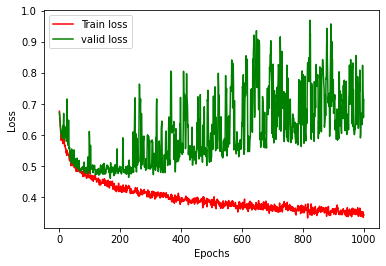

In [19]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,epochs)],[j.cpu().detach().numpy() for j in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

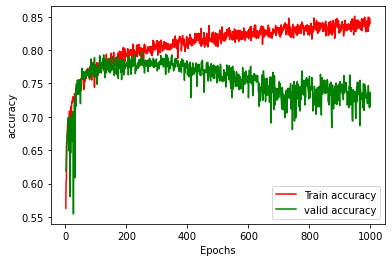

In [20]:
plt.plot([i for i in range(1,epochs)],[i  for i  in traine_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,epochs)],[j for j in vale_accuracy],label="valid accuracy",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()

In [21]:
print(f"Training loss|   Mean: {torch.tensor(epoch_loss).mean()}   std: {torch.tensor(epoch_loss).std()}")
print(f"validation loss| Mean: {torch.tensor(valida_loss).mean()}  std: {torch.tensor(valida_loss).std()}")
# print(f"Test loss|       Mean: {torch.tensor(test_loss).mean()}   std: {torch.tensor(test_loss).std()}")

Training loss|   Mean: 0.3997141122817993   std: 0.051300473511219025
validation loss| Mean: 0.6143194437026978  std: 0.11056607216596603
